In [ ]:
%%bash
python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

In [ ]:
%%bash
pip install gdown
gdown --id 1AM167Pj09zrYhz5wApOfx1ZK4jCe6bs8

In [3]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [4]:
!unzip arabic.zip > /dev/null

In [5]:
import json
import os
from detectron2.structures import BoxMode
def get_board_dicts(imgdir):
    json_file = imgdir+"/dataset.json" #Fetch the json file
    with open(json_file) as f:
        dataset_dicts = json.load(f)
    for i in dataset_dicts:
        filename = i["file_name"] 
        i["file_name"] = imgdir+"/"+filename 
        for j in i["annotations"]:
            j["bbox_mode"] = BoxMode.XYXY_ABS #Setting the required Box Mode
            j["category_id"] = int(j["category_id"])
    return dataset_dicts
from detectron2.data import DatasetCatalog, MetadataCatalog
#Registering the Dataset
for d in ["train", "val"]:
    DatasetCatalog.register("arabic_" + d, lambda d=d: get_board_dicts("./arabic/" + d))
    MetadataCatalog.get("arabic_" + d).set(thing_classes=["Id","Date"])
balloon_metadata = MetadataCatalog.get("arabic_train")

In [6]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("arabic_train",)
cfg.DATASETS.TEST = ()   # no metrics implemented for this dataset
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml")  # initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 2000
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2  # only has one class (ballon)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[11/15 13:03:29 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_a3ec72.pkl: 254MB [00:05, 48.0MB/s]                              


[11/15 13:03:42 d2.engine.train_loop]: Starting training from iteration 0
[11/15 13:04:04 d2.utils.events]:  eta: 0:21:02  iter: 19  total_loss: 2.31  loss_cls: 1.16  loss_box_reg: 0.02403  loss_mask: 0.6912  loss_rpn_cls: 0.3738  loss_rpn_loc: 0.04671  time: 0.6097  data_time: 0.0233  lr: 4.9953e-06  max_mem: 3817M
[11/15 13:04:16 d2.utils.events]:  eta: 0:21:11  iter: 39  total_loss: 2.012  loss_cls: 0.9156  loss_box_reg: 0.03669  loss_mask: 0.686  loss_rpn_cls: 0.2658  loss_rpn_loc: 0.04068  time: 0.6226  data_time: 0.0109  lr: 9.9902e-06  max_mem: 3817M
[11/15 13:04:29 d2.utils.events]:  eta: 0:21:09  iter: 59  total_loss: 1.61  loss_cls: 0.5653  loss_box_reg: 0.08782  loss_mask: 0.6731  loss_rpn_cls: 0.24  loss_rpn_loc: 0.03451  time: 0.6241  data_time: 0.0114  lr: 1.4985e-05  max_mem: 3817M
[11/15 13:04:42 d2.utils.events]:  eta: 0:21:14  iter: 79  total_loss: 1.342  loss_cls: 0.3862  loss_box_reg: 0.1357  loss_mask: 0.654  loss_rpn_cls: 0.1377  loss_rpn_loc: 0.03239  time: 0.632

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg.DATASETS.TEST = ("arabic_val", )
predictor = DefaultPredictor(cfg)

outputs are:  {'instances': Instances(num_instances=2, image_height=790, image_width=1322, fields=[pred_boxes: Boxes(tensor([[ 924.2040,  197.4856, 1297.4456,  292.3372],
        [ 218.9048,   89.7008,  397.1372,  192.8102]], device='cuda:0')), scores: tensor([0.9991, 0.9981], device='cuda:0'), pred_classes: tensor([1, 0], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, F

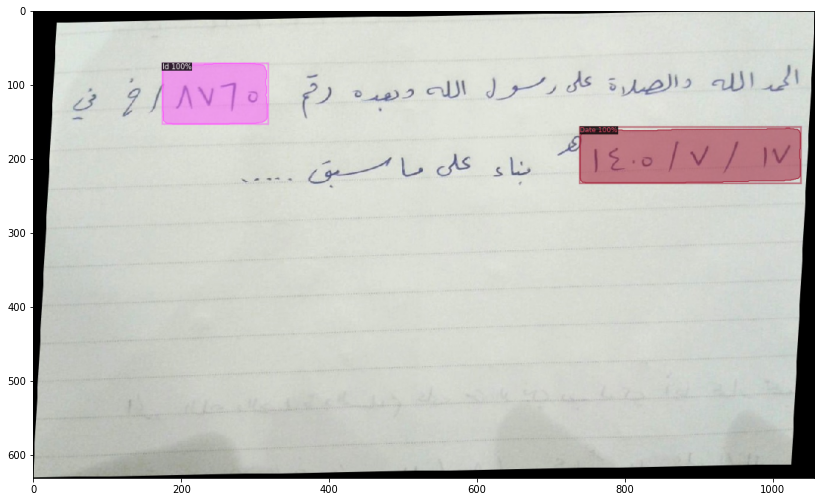

outputs are:  {'instances': Instances(num_instances=2, image_height=265, image_width=986, fields=[pred_boxes: Boxes(tensor([[207.7930, 187.1050, 430.0547, 245.8372],
        [521.8056, 173.7467, 629.0788, 224.2344]], device='cuda:0')), scores: tensor([0.9986, 0.9967], device='cuda:0'), pred_classes: tensor([1, 0], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..

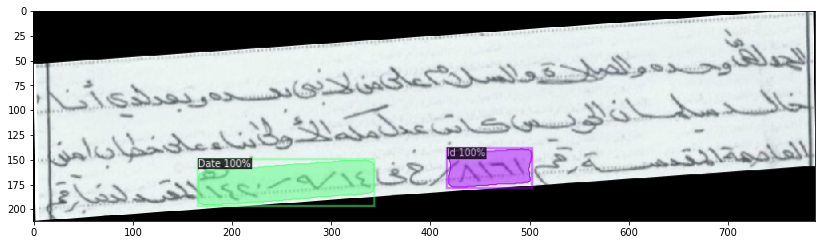

outputs are:  {'instances': Instances(num_instances=2, image_height=939, image_width=1375, fields=[pred_boxes: Boxes(tensor([[ 957.8031,  320.7895, 1335.1151,  460.8785],
        [ 265.6564,   95.3663,  453.0205,  223.7999]], device='cuda:0')), scores: tensor([0.9997, 0.9975], device='cuda:0'), pred_classes: tensor([1, 0], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, F

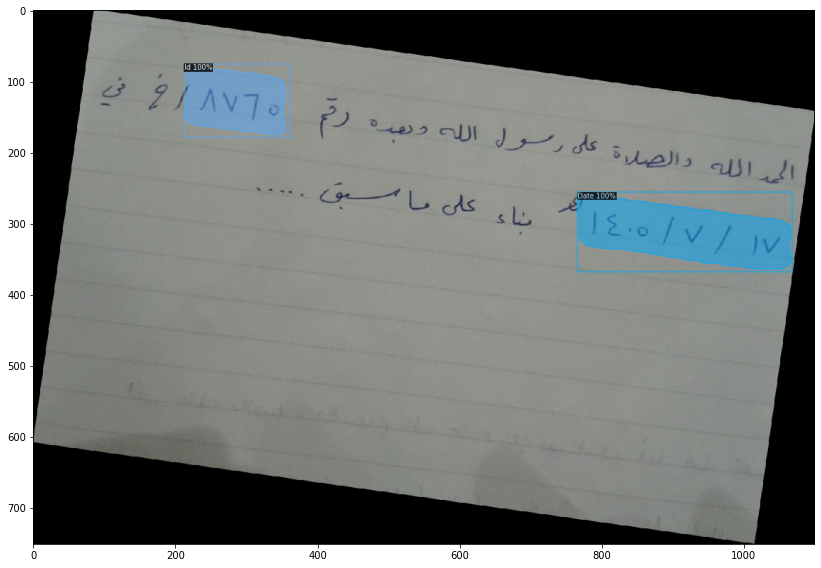

In [8]:
from detectron2.utils.visualizer import ColorMode
import random

dataset_dicts = get_board_dicts("arabic/val")
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    print('outputs are: ',outputs)
    v = Visualizer(im[:, :, ::-1], metadata=balloon_metadata, scale=0.8)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

outputs are:  {'instances': Instances(num_instances=2, image_height=768, image_width=1280, fields=[pred_boxes: Boxes(tensor([[ 509.2216,  212.3278,  820.8403,  304.8702],
        [ 982.3142,  207.1815, 1143.5482,  304.2874]], device='cuda:0')), scores: tensor([0.9878, 0.8076], device='cuda:0'), pred_classes: tensor([1, 0], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, F

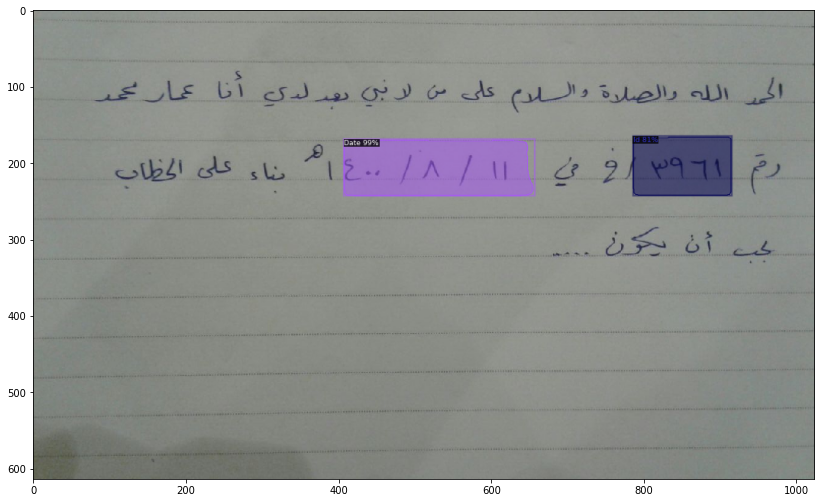

In [9]:
#dataset_dicts = get_board_dicts("arabic/val")
#for d in random.sample(dataset_dicts, 3):    
im = cv2.imread('./val_img.jpg')
outputs = predictor(im)
print('outputs are: ',outputs)
v = Visualizer(im[:, :, ::-1], metadata=balloon_metadata, scale=0.8)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize = (14, 10))
plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
plt.show()

In [10]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("arabic_val", ("bbox",), False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "arabic_val")
print(inference_on_dataset(trainer.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

[11/15 13:29:44 d2.evaluation.coco_evaluation]: Trying to convert 'arabic_val' to COCO format ...
[11/15 13:29:44 d2.data.datasets.coco]: Converting annotations of dataset 'arabic_val' to COCO format ...)
[11/15 13:29:44 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[11/15 13:29:44 d2.data.datasets.coco]: Conversion finished, #images: 90, #annotations: 180
[11/15 13:29:44 d2.data.datasets.coco]: Caching COCO format annotations at './output/arabic_val_coco_format.json' ...
[11/15 13:29:44 d2.data.build]: Distribution of instances among all 2 categories:
|  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|
|     Id     | 90           |    Date    | 90           |
|            |              |            |              |
|   total    | 180          |            |              |
[11/15 13:29:44 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(80

In [ ]:
print(cfg.dump())

In [11]:
f = open('config.yml', 'w')
f.write(cfg.dump())
f.close()

***The code below for downloading pretrained model***

In [ ]:
#%%bash
#pip install gdown
#gdown --id  id of config.yml
#gdown --id  id of model_final

In [ ]:
#%%bash
# we create output folder because in train stage 
# we save tha path of the model in output folder
# so we can change it to become in any path
#mkdir output
#cp ./model_final.pth ./output

In [ ]:
#from detectron2.config import get_cfg
#cfg = get_cfg()
#cfg.merge_from_file("./config.yml")
#print(cfg.dump())

In [ ]:
#predictor = DefaultPredictor(cfg)

In [ ]:
#from detectron2.utils.visualizer import ColorMode
#import random

dataset_dicts = get_board_dicts("arabic/val")
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1], metadata=balloon_metadata, scale=0.8)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()